In [1]:
# !pip install tensorflow gym keras-rl gym[atari]
!pip install tensorflow gym keras-rl 'gym[atari]' 'gym[accept-rom-license]' opencv-python
# !pip install opencv-python

In [2]:
import gym 
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

Pre-proccessing 

In [3]:
def resize_frame(frame):
    frame = np.average(frame,axis = 2)
    frame = frame[30:-5,:]
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    frame = np.expand_dims(frame, axis=-1)
    frame = np.repeat(frame, 3, axis=-1)
    return frame

In [4]:
def extract_frame(input, focal_point, x_len, y_len):
    max_x, max_y = np.shape(input)
    x,y = focal_point
    x_half = x_len / 2
    y_half = y_len /2
    x_left = x - x_half
    x_right = x + x_half
    y_up = y + y_half
    y_down = y - y_half
    if x_left < 0:
        x_left = 0
    if x_right > max_x - 1:
        x_right = max_x - 1
    if y_up > max_y - 1:
        y_up = max_y - 1
    if y_down < 0:
        y_down = 0
    frame = input[x_left:x_right, y_down:y_up]
    return frame

Class For Memory Buffer

In [5]:
class Memory(object):
    def __init__(self, input_shape, num_actions, buffer_size, batch_size):
        self.states = np.zeros((buffer_size,) + input_shape)
        self.next_states = np.zeros((buffer_size,) + input_shape)
        self.actions = np.zeros(buffer_size, dtype=np.uint8)
        self.rewards = np.zeros(buffer_size)
        self.terminal = np.zeros(buffer_size)
        self.buffer_index = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    def save_action(self, state, action, reward, next_state, done):
        self.states[self.buffer_index] = state
        self.next_states[self.buffer_index] = next_state
        self.actions[self.buffer_index] = action
        self.rewards[self.buffer_index] = reward
        self.terminal[self.buffer_index] = 1 - int(done)
        self.buffer_index = (self.buffer_index + 1) % self.buffer_size

    def sample_memory(self):
        indicies = np.random.randint(0, self.buffer_size, self.batch_size)
        return self.states[indicies], self.actions[indicies], self.rewards[indicies], self.next_states[indicies], self.terminal[indicies]
    



Function For Deep Q Network

In [6]:
#from keras exactly, site if using!!!
def init_deep_q_network(input_shape, lr, num_actions, l1_size, l2_size):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

Class For Learning Agent

In [7]:
class Agent(object):
    def __init__(self, alpha, gamma, actions_amt, epsilon, batch_size, input_shape, epsilon_dec=0.996, epsilon_end=0.01, mem_size=10000, fname='dqn_model.h5', buffer_size=1000):
        self.alpha = alpha
        self.gamma = gamma
        self.actions_amt = actions_amt
        self.epsilon = epsilon 
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.mem_size = mem_size
        self.fname = fname
        self.q_network = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.q_network_target = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.memory = Memory(input_shape, actions_amt, buffer_size, batch_size)
        self.loss_function = keras.losses.Huber()
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.model_file = "rl_agent"


    def select_action(self, input): 
        if np.random.rand() > self.epsilon:
            action_values = self.q_network.predict(input[None,...], verbose=0)
            action = np.argmax(action_values)
        else:
            action = np.random.choice(self.actions_amt)
        
        return action 
    
    def store_action(self, state, action, reward, next_state, done):
        self.memory.save_action(state, action, reward, next_state, done)

    def learn(self):
        #print("calling learn")
        states, actions, rewards, new_states, dones = self.memory.sample_memory()
        states = tf.stack(states)
        actions = tf.stack(actions)
        new_states = tf.stack(new_states)
        dones = tf.stack(dones)
        new_states = tf.stack(new_states)
        future_rewards = self.q_network_target.predict(new_states, verbose=0)
        updated_qs = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1)
        masks = tf.one_hot(actions, self.actions_amt)
        #print("before gradient tape section")
        with tf.GradientTape() as tape:
            q_values = self.q_network(states)
            q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            loss = self.loss_function(updated_qs, q_actions)
        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))
        self.q_network_target.set_weights(self.q_network.get_weights())
        
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_dec

    def save_model(self):
        self.q_network.save(self.model_file)

    def load_model(self):
        self.q_network = load_model(self.model_file)
        

        

Run Learning Loop

In [15]:
env = gym.make('Breakout-v4')
# env = gym.make('Breakout-v4', render_mode='human')
n_games = 70
agent = Agent(gamma=.99, epsilon=.05, alpha=.0005, actions_amt=4, input_shape=(84, 84, 3) , mem_size=100, batch_size=64, epsilon_end=0.01, buffer_size=1000, epsilon_dec=.001)

# observation = env.reset()
# observation = observation[0]
# observation = resize_frame(observation)
# plt.imshow(observation) #temporary

scores = []
avg_scores = []
eps_history = []

In [16]:
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    observation = observation[0]
    observation = resize_frame(observation)
    while not done: 
        # env.render()
        action = agent.select_action(observation)
        observation_, reward, done, truncated, info = env.step(action)
        observation_ = resize_frame(observation_)
        agent.store_action(observation, action, reward, observation_, done)
        observation = observation_
        score += reward
    agent.learn()

    eps_history.append(agent.epsilon)
    scores.append(score)
    score = 0

    avg_score = np.mean(scores[max(0, 1 - 100):(i + 1)])
    avg_scores.append(avg_score)
    if i % 10 == 0:
        print("episode ", i, "score %.2f" % score, 'average score %.2f' % avg_score)

    #if i % 10 == 0 and i > 0: 
        #agent.save_model()

episode  0 score 0.00 average score 0.00
episode  10 score 0.00 average score 2.27
episode  20 score 0.00 average score 1.81
episode  30 score 0.00 average score 1.71
episode  40 score 0.00 average score 1.54
episode  50 score 0.00 average score 1.55
episode  60 score 0.00 average score 1.56


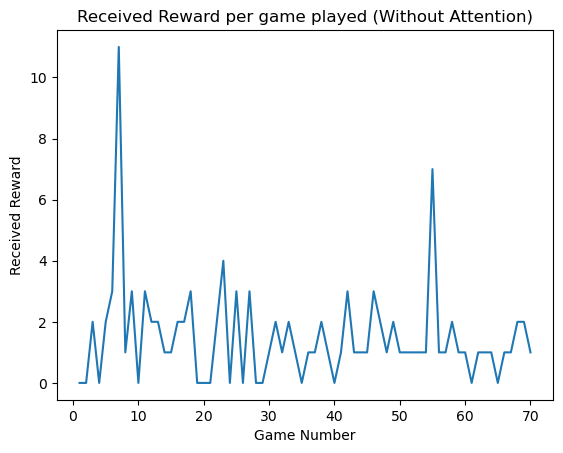

In [23]:
def plot_line_chart(scores):
    # Generate x-axis values (assuming scores are evenly spaced)
    x_values = range(1, len(scores) + 1)

    # Plot the line chart
    plt.plot(x_values, scores, linestyle='-')

    # Add labels and title
    plt.xlabel('Game Number')
    plt.ylabel('Received Reward')
    plt.title('Received Reward per game played (Without Attention)')

    # Display the chart
    plt.show()

# Example usage:
plot_line_chart(scores)

In [11]:
RL